## Model 1
A simple model to classify hand-written alpha-numeric charecters as alpha or numeric, is defined in this notebook.

The following sources were referenced:
1. https://www.dataquest.io/blog/how-to-share-data-science-portfolio/ 
2. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
3. https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf 


In [ ]:
## TODO : Function to read dataframe and return the images and lables array generated

def images_labels(data_df):
    labels = data_df.iloc[:,0].values
    images = data_df.iloc[:,1:].values.reshape(len(data_df),28,28,1,order='F') ## column major ordering
    images = images/255.0
    return labels,images

In [3]:
# Get the test, train and validation sets

DATASET_PATH = r'.\Character + Digits data\\'

test_data = pd.read_csv(DATASET_PATH+'characters-digits-test.csv',header=None)
test_labels,test_images = images_labels(test_data)

train_dataSet = pd.read_csv(DATASET_PATH+'characters-digits-train.csv',header=None)
train_df, val_df = train_test_split(train_dataSet, test_size=0.2)

train_labels, train_images = images_labels(train_df)
val_labels, val_images = images_labels(val_df)

In [4]:
print('train :' ,(train_labels.shape, train_images.shape))
print('validation :' ,(val_labels.shape, val_images.shape))
print('test :' ,(test_labels.shape, test_images.shape),'\n')

# checking the distribution of test labels
print(np.unique(train_labels,return_counts=True)) # : no significant class imabalnce

train : ((90240,), (90240, 28, 28, 1))
validation : ((22560,), (22560, 28, 28, 1))
test : ((18800,), (18800, 28, 28, 1)) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=int64), array([1947, 1919, 1933, 1940, 1951, 1903, 1926, 1925, 1900, 1922, 1935,
       1939, 1960, 1915, 1914, 1928, 1891, 1922, 1926, 1908, 1924, 1911,
       1904, 1937, 1920, 1923, 1900, 1967, 1914, 1913, 1913, 1877, 1908,
       1897, 1872, 1957, 1933, 1915, 1927, 1912, 1900, 1964, 1917, 1908,
       1928, 1906, 1889], dtype=int64))


In [6]:
# TODO : convert class lables to boolean --> 1 for int , 0 for char lables. 
''' 
The mapping file has ascii codes for the labels
 logic : val < 10 : int ( 1 label) , val > 10 : char ( 0 label)
'''

test_labels_bool = test_labels < 10
test_labels_binary = test_labels_bool.astype(int)

val_labels_bool = val_labels < 10
val_labels_binary = val_labels_bool.astype(int)


train_labels_bool = train_labels < 10
train_labels_binary = train_labels_bool.astype(int)

_,class_labels = np.unique(train_labels_binary,return_counts=True)
print((class_labels/len(train_labels_binary))*100) ## classification imbalance  : (alpha : 79%) , (num :21%)

[78.65026596 21.34973404]


In [7]:
## TODO : Define the model and the required metrics 


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = keras.models.Sequential([
      keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28,1)),
      keras.layers.MaxPooling2D(2, 2),
      keras.layers.Conv2D(64, (3,3), activation='relu'),
      keras.layers.MaxPooling2D(2,2),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dropout(0.5),  
      keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [8]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [16]:
## setting up initial bias :
initial_bias = np.log([class_labels[1]/class_labels[0]])
print(initial_bias)

[-1.30397173]


In [17]:
## checking if the model works.
model = make_model(output_bias = initial_bias)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [13]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels_binary),
                                                 train_labels_binary)
print(class_weights)

[0.63572576 2.34194955]


In [21]:
weighted_model = make_model()
# weighted_model.load_weights(initial_weights)
EPOCHS = 100
BATCH_SIZE = 1024

weighted_history = weighted_model.fit(
    train_images,
    train_labels_binary,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_images, val_labels_binary),
    class_weight=class_weight) 

Train on 90240 samples, validate on 22560 samples
Epoch 1/100
90240/90240 [==============================] - 48s 529us/sample - loss: 0.3695 - tp: 7149.0000 - fp: 3042.0000 - tn: 67932.0000 - fn: 12117.0000 - accuracy: 0.8320 - precision: 0.7015 - recall: 0.3711 - auc: 0.8531 - val_loss: 0.3100 - val_tp: 3375.0000 - val_fp: 1681.0000 - val_tn: 16145.0000 - val_fn: 1359.0000 - val_accuracy: 0.8652 - val_precision: 0.6675 - val_recall: 0.7129 - val_auc: 0.9150
Epoch 2/100
90240/90240 [==============================] - 47s 524us/sample - loss: 0.2802 - tp: 11399.0000 - fp: 3545.0000 - tn: 67429.0000 - fn: 7867.0000 - accuracy: 0.8735 - precision: 0.7628 - recall: 0.5917 - auc: 0.9233 - val_loss: 0.2520 - val_tp: 2648.0000 - val_fp: 552.0000 - val_tn: 17274.0000 - val_fn: 2086.0000 - val_accuracy: 0.8831 - val_precision: 0.8275 - val_recall: 0.5594 - val_auc: 0.9403
Epoch 3/100
90240/90240 [==============================] - 47s 524us/sample - loss: 0.2439 - tp: 12708.0000 - fp: 3376.0000 -

Epoch 21/100
90240/90240 [==============================] - 47s 524us/sample - loss: 0.1341 - tp: 15867.0000 - fp: 2193.0000 - tn: 68781.0000 - fn: 3399.0000 - accuracy: 0.9380 - precision: 0.8786 - recall: 0.8236 - auc: 0.9831 - val_loss: 0.1551 - val_tp: 3645.0000 - val_fp: 474.0000 - val_tn: 17352.0000 - val_fn: 1089.0000 - val_accuracy: 0.9307 - val_precision: 0.8849 - val_recall: 0.7700 - val_auc: 0.9774
Epoch 22/100
90240/90240 [==============================] - 47s 522us/sample - loss: 0.1309 - tp: 15932.0000 - fp: 2113.0000 - tn: 68861.0000 - fn: 3334.0000 - accuracy: 0.9396 - precision: 0.8829 - recall: 0.8269 - auc: 0.9839 - val_loss: 0.1508 - val_tp: 3712.0000 - val_fp: 479.0000 - val_tn: 17347.0000 - val_fn: 1022.0000 - val_accuracy: 0.9335 - val_precision: 0.8857 - val_recall: 0.7841 - val_auc: 0.9783
Epoch 23/100
90240/90240 [==============================] - 47s 523us/sample - loss: 0.1281 - tp: 15914.0000 - fp: 2113.0000 - tn: 68861.0000 - fn: 3352.0000 - accuracy: 0.93

In [38]:
weighted_model.save('task1_v2.h5')

In [23]:
## TODO : plot the model results 

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()


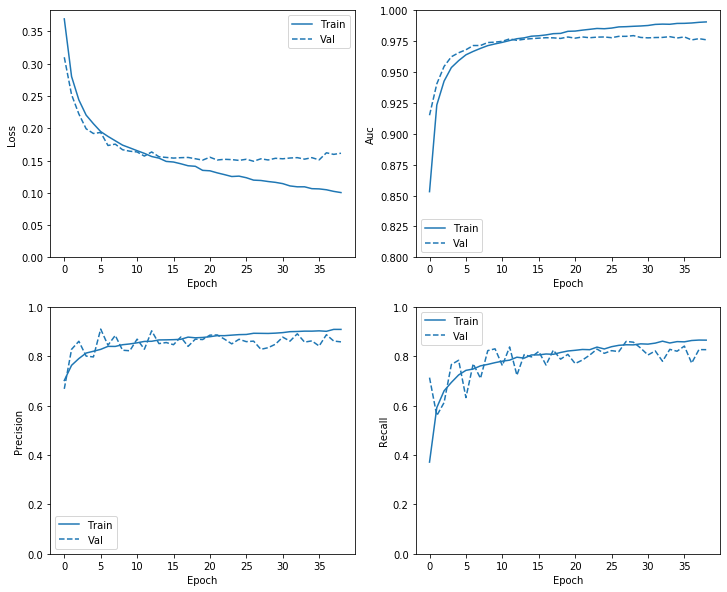

In [25]:
plot_metrics(weighted_history)

In [36]:
## TODO : plot the confusion matrix 

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Alphabet Detected Correctly : ', cm[0][0])
    print('Alphabet missed : ', cm[0][1])
    print('Numeric values Detected Correctly : ', cm[1][1]) 
    print('Numeric values Missed : ', cm[1][0])
    print('Total numeric values : ', np.sum(cm[1]))

loss :  0.15122602599098328
tp :  3417.0
fp :  654.0
tn :  14146.0
fn :  583.0
accuracy :  0.93420213
precision :  0.83935153
recall :  0.85425
auc :  0.97848535

Alphabet Detected Correctly :  14146
Alphabet missed :  654
Numeric values Detected Correctly :  3417
Numeric values Missed :  583
Total numeric values Correctly:  4000


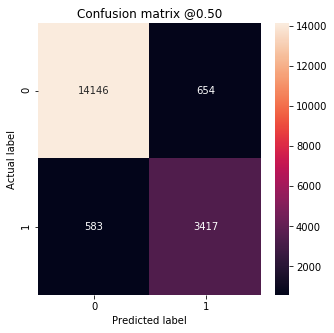

In [37]:
## evalution of model performance on test data
weighted_results = weighted_model.evaluate(test_images, test_labels_binary,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

test_predictions_weighted = weighted_model.predict(test_images, batch_size=BATCH_SIZE) 
plot_cm(test_labels_binary, test_predictions_weighted)